# Graph Regression

With an understanding of basis functions on graphs, we can consider how to use those basis functions as representations of data points for machine learning.

In [ ]:
import sklearn
from sklearn import datasets
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
import numpy as np
import time
from scipy.sparse.csgraph import laplacian
from scipy.sparse.linalg import eigsh
from numpy.linalg import eig
from numpy import linalg as la
import pandas as pd
import sys

np.set_printoptions(threshold=sys.maxsize)

### Visualize data

In [40]:
def gen_clusters():
    """Generates two clusters of data and their corresponding labels. Points are
    labeled 1 if they are on the inside of the swiss roll, 0 if they are on the
    outside of the swiss roll.
    Returns:
        cluster_1 ((6 x 3) np.ndarray): the first cluster of data
        cluster_2 ((9 x 3) np.ndarray): the second cluster of data
        labels_1 ((6 x 1) np.ndarray): the labels for the first set of data points
        labels_2 ((9 x 1) np.ndarray): the labels for the second set of data points
    """
    cluster_1 = np.array([                          
                         [ -0.96465601,   7.90195605,   7.91667933],
                         [  5.61553006,   3.86016425,   4.01646273],
                         [  6.15892401,   2.73288038,  -0.59218982],
                         [  2.25183243,   6.05179238,  -4.64676804],
                         [  4.91677882,   2.42326792,  -2.96340473],
                         [ -6.56370511,   7.13848534,   5.72215369],
                         ])
    cluster_2 = np.array([
                         [ 11.38920717,  14.92140348,   6.43324725],
                         [  2.1079105,   20.71412712,  13.82611173],
                         [ 12.60543362,  19.19465939,   1.10891728],
                         [  5.80171168,  18.06536926,  -9.95611463],
                         [  1.36262826,  17.20606583, -11.03462404],
                         [  7.90516102,  16.82515341,  -8.67248813],
                         [ 10.81257788,  14.72056388,  -5.43290428],
                         [ 11.08920938,  11.75993012,  -4.95555382],
                         [  5.37231179,  13.67154943,  12.64107991],
                         ])
    return np.vstack((cluster_1, cluster_2)), np.hstack((np.ones(len(cluster_1)), np.zeros(len(cluster_2))))

def plot_clusters():
    """Plots the unlabeled dataset and the generated (labeled) clusters."""
    cmap = 'rainbow'
    # Collect unlabeled data points
    data_unlabeled, _ = datasets.make_swiss_roll(n_samples=500)
    # Plot unlabeled points
    fig = plt.figure(figsize=(15, 5))
    ax = fig.add_subplot(1, 3, 1, projection='3d')
    ax.scatter(data_unlabeled[:, 0], data_unlabeled[:, 1], data_unlabeled[:, 2],
               s=20, 
               cmap='viridis',
               edgecolor='k')
    plt.title("Original Data Manifold")
    
    # Collect labeled data points
    data, labels = gen_clusters()
    # Plot labeled points
    ax = fig.add_subplot(1, 3, 2, projection='3d')
    ax.scatter(data[:, 0], data[:, 1], data[:, 2],
               c=labels,
               s=20, 
               cmap=cmap,
               edgecolor='k')
    plt.title("Labeled Data Points")
    
    # Plot labeled and unlabeled points together
    ax = fig.add_subplot(1, 3, 3, projection='3d')
    ax.scatter(data_unlabeled[:, 0], data_unlabeled[:, 1], data_unlabeled[:, 2],
               s=20, 
               cmap=cmap,
               edgecolor='k')
    ax.scatter(data[:, 0], data[:, 1], data[:, 2],
               c=labels,
               s=20, 
               cmap=cmap,
               edgecolor='k')
    plt.title("Labeled and Unlabeled Data Points")

Consider the following dataset. There are many unlabeled points and just a few labeled points. The points are labeled according to their closeness to the center of the swiss roll.

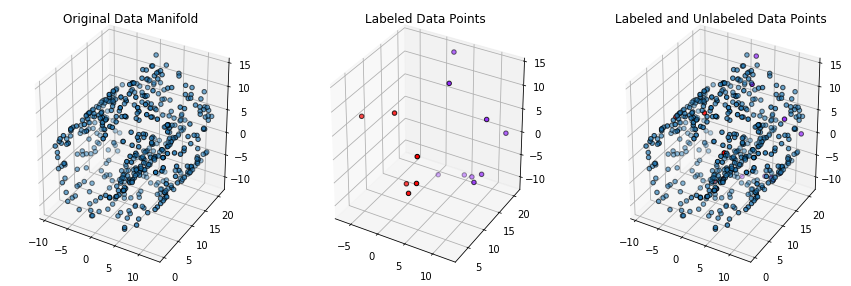

In [41]:
plot_clusters()

### Function to conduct linear regression

In [55]:
def graph_regression(n_samples=1000, n_eig_vecs=10):
    """Compares regression to Euclidean coordinates with regression to graph basis function coordinates.
    Args:
        n_samples (int): the number of samples for generating the dataset
        n_eig_vecs (int): the number of graph basis functions to use
    """
    data_unlabeled, _ = datasets.make_swiss_roll(n_samples=n_samples)
    data_labeled, labels = gen_clusters()
    n_labels = len(labels)
    
    # Append new clusters to data
    data = np.vstack((data_unlabeled, data_labeled))
    labels = np.hstack((.5*np.ones(n_samples), labels))
    # Regress label to Euclidean coordinates
    A = data_labeled
    b = labels[-n_labels:]
    
    x_hat = la.solve(A.T @ A, A.T @ b)
    pred_labels = data @ x_hat
    
    # Plot predicted labels
    fig = plt.figure(figsize=(15, 7))
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    ax.scatter(data[:, 0], data[:, 1], data[:, 2],
               c=pred_labels,
               s=20, 
               cmap='jet',
               edgecolor='k')
    plt.title("Regression to Euclidean Coordinates")
    
    # Regress label to graph basis function coordinates
    
    # Make the graph
    adj_matrix = sklearn.neighbors.kneighbors_graph(
        data, 
        n_neighbors=10, 
        mode='connectivity',
        metric='minkowski', 
        p=2, 
        metric_params=None, 
        include_self=False, 
        n_jobs=None
    )
    # Symmetrize the adjacency matrix
    adj_matrix = np.maximum( adj_matrix.todense(), adj_matrix.todense().T )

    laplace = laplacian(adj_matrix, normed=True)

    # eigsh gets eigenvectors and values from the graph laplacian
    eig_vals, eig_vecs = eigsh(laplace, k=n_eig_vecs, which='SM')
    
    # Regress label to graph eigenfunction coordinates
    A = eig_vecs[-n_labels:, :]
    b = labels[-n_labels:]
    x_hat = la.solve(A.T @ A, A.T @ b)
    pred_labels = eig_vecs @ x_hat
    
    # Plot predicted labels
    ax = fig.add_subplot(1, 2, 2, projection='3d')
    ax.scatter(data[:, 0], data[:, 1], data[:, 2],
               c=pred_labels,
               s=20, 
               cmap='jet',
               edgecolor='k')
    plt.title("Regression to Graph Basis Function Coordinates")
    
    plt.show()

Now, we plot the entire dataset colored according to their representation in linear regression to Euclidean coordinates vs. linear regression to graph coordinates. Notice that the gradient of labels in Euclidean coordinate regression ignores the manifold of the data, while the gradient of labels in graph basis function regression follows the manifold of the data. With just 15 labeled data points, graph coordinate regression fully represents the function that generated the data. This illustrates how helpful a graph representation of data can be for machine learning.

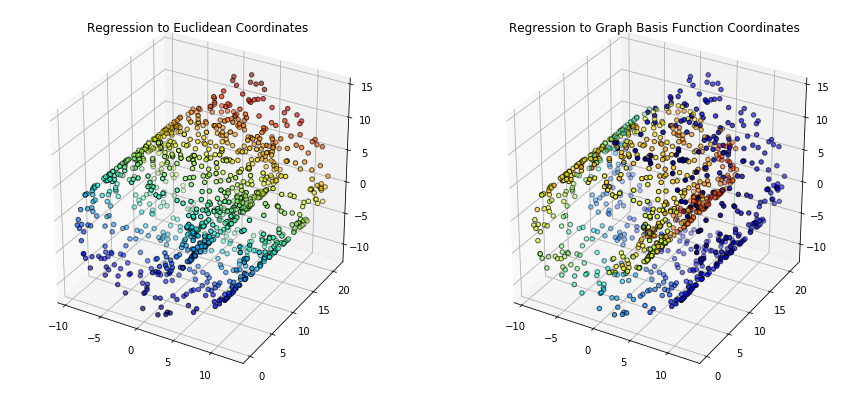

In [56]:
graph_regression()